In [1]:
#Usaremos el set de datos mnist de TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
#Descargar el set de datos con metadatos
datos, metadatos = tfds.load("mnist",as_supervised=True, with_info=True)

In [3]:
metadatos

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='C:\\Users\\eobga\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [4]:
datos_entrenamiento = datos["train"]
datos_pruebas = datos["test"]

In [5]:
nombres_clases = metadatos.features["label"].names

In [6]:
#Normalizacion
#0-255 (valores de pixeles <<Blanco-negro>>) La normalizacion cambia esto de (0-1)
#Transformar 0-255 -> 0-1 (0=0 , 255 = 1) por lo cual 127=.5

#Normalizar los datos de entrenamiento y prueba
def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32) #convertir imagenes a float para poder dividirlo
    imagenes = imagenes/255 #dividirlo en 255 para tener 0-1
    return imagenes, etiquetas

datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar en cache para que los guarde en memoria ,esto hara que las siguientes vueltas sean mas rapidas
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

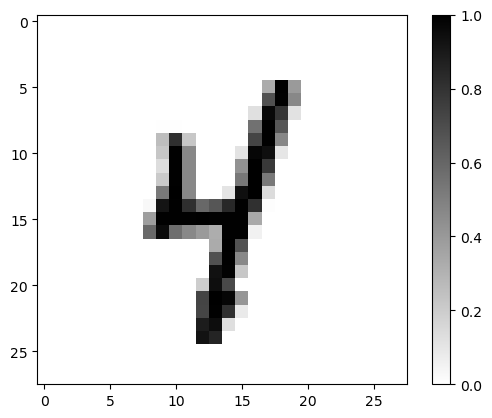

In [7]:
#Mostrar 1 dato en pantalla
for imagen, etiqueta in datos_entrenamiento.take(1):
    break

import matplotlib.pyplot as plt 

#Mostrarlo en pantalla
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary) #Solo pintar blanco y negro
plt.colorbar() #Agregar barra de colores para observar el (0-1)
plt.show()

In [8]:
#Creacion del modelo
"""modelo = tf.keras.Sequential([
    #784 datos de entrada(pixeles en la imagen) capa de entrada
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 = blanco y negro
    # # # Capa oculta
    tf.keras.layers.Dense(50, activation=tf.nn.relu ),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    #capa de salida    
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) #Tamano del tipo de datos. (0-9)
])""" 

#nuevo modelo
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape = (28, 28, 1), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2), #Crea cuadros de 2x2 y se va moviendo para hacer la imagen mas pequena ( sirve para agarrar lo mas importante)
    
    #podemos agregar mas capas con filtros ya que la imagen es mas pequena
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),

    #al ser imagenes chiquitas ya no necesitamos mas. Pero en imagenes mas grandes , si es recomendado

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'), #No es obligatiorio esta capa, pero nos ayuda bastante.
    tf.keras.layers.Dense(10, activation='softmax')
])

#Este modelo debemos ir experimentando segun nuestros datos


In [9]:
modelo.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), #le permite al modelo ajustarse de manera adecuada a la clasificacion
    metrics = ["accuracy"] #Precision
)

In [10]:
#Necesitamos optimizar al modelo para poder entrenarlo con los 60 mil datos
TAMANO_LOTE = 32; #El modelo ira de 32 en 32 datos 

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(60000).batch(TAMANO_LOTE) #Esto hara que se repita, que los datos vengan revueltos y que lo haga en lotes
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE) #Especificar los lotes

In [11]:
import math

#Entrenar
entrenamiento = modelo.fit(
    datos_entrenamiento, epochs=10,
    steps_per_epoch = math.ceil(60000/TAMANO_LOTE)
)

Epoch 1/10


1875/1875 [==============================] - 31s 14ms/step - loss: 0.1316 - accuracy: 0.9599
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0434 - accuracy: 0.9871
Epoch 3/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0296 - accuracy: 0.9908
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0203 - accuracy: 0.9934
Epoch 5/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0172 - accuracy: 0.9944
Epoch 6/10
1875/1875 [==============================] - 25s 14ms/step - loss: 0.0119 - accuracy: 0.9961
Epoch 7/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0101 - accuracy: 0.9967
Epoch 8/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0089 - accuracy: 0.9971
Epoch 9/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0082 - accuracy: 0.9973
Epoch 10/10
1875/1875 [==============================] - 23s 12ms/step - lo

1/1 [==============================] - 1s 526ms/step


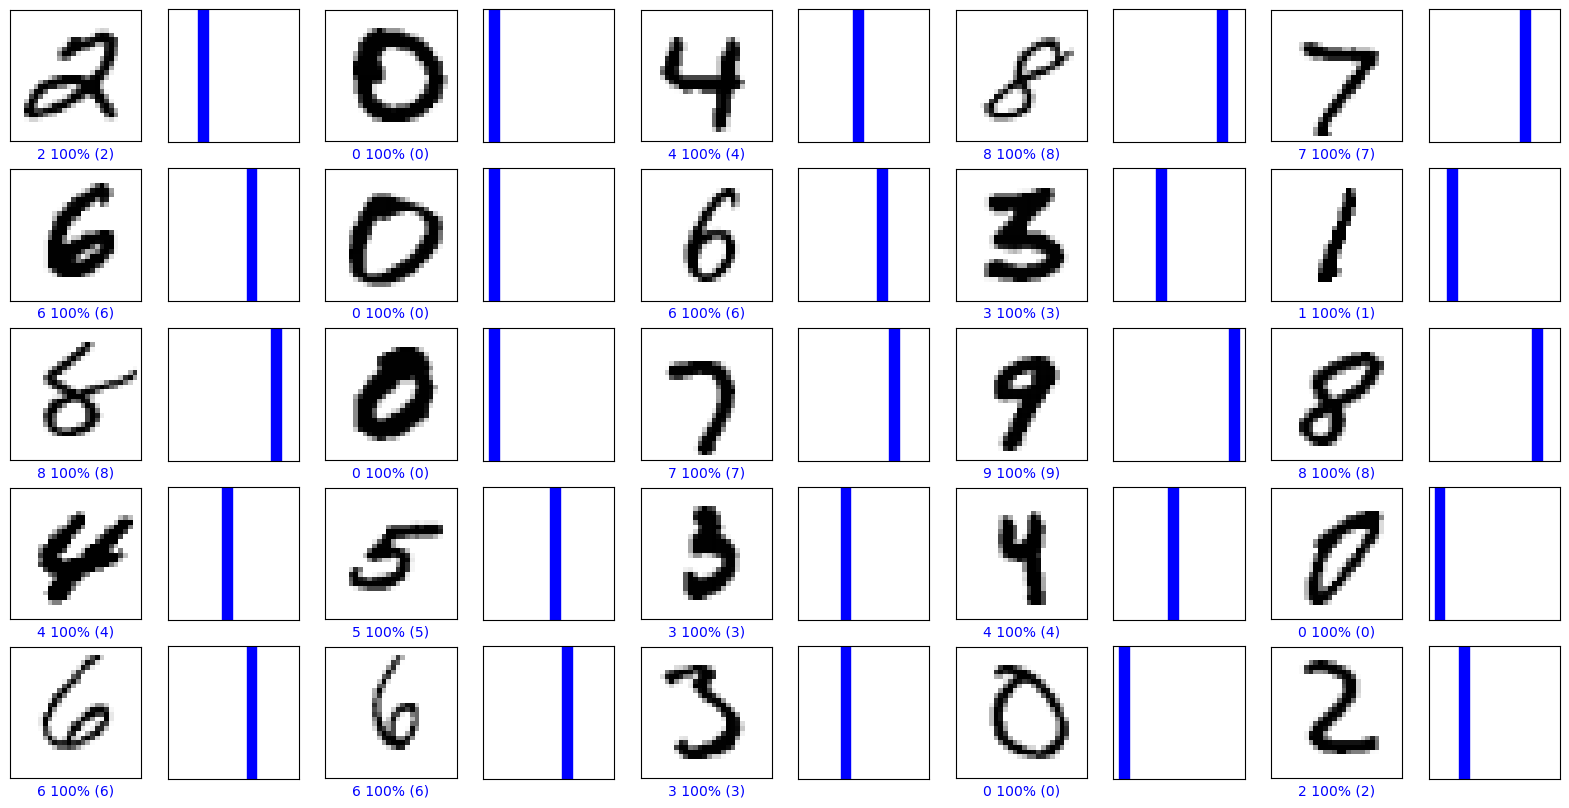

In [12]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)